<a href="https://colab.research.google.com/github/95ImadEL/Tensorflow-basics/blob/main/Scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Are we using a GPU?
!nvidia-smi

Tue Jan 24 14:11:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-24 14:11:32--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-24 14:11:32 (67.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [4]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-01-24 14:13:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.250.31.128, 142.251.16.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  19.4MB/s    in 16s     

2023-01-24 14:13:27 (97.9 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
import tensorflow as tf

IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size = IMG_SIZE
    )

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size = IMG_SIZE,
    shuffle=False
    )

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [6]:
# Create checkpoint callback to save model for later user

checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

In [8]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  layers.RandomRotation(0.2), # randomly rotate images by a specific amount
  layers.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  layers.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  layers.RandomZoom(0.2), # randomly zoom into an image
  # layers.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

In [9]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [10]:
# Get a summary of our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [11]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
237/237 [==============================] - 95s 343ms/step - loss: 3.3690 - accuracy: 0.2776 - val_loss: 2.4001 - val_accuracy: 0.4942
Epoch 2/5
237/237 [==============================] - 63s 265ms/step - loss: 2.1981 - accuracy: 0.5020 - val_loss: 1.9868 - val_accuracy: 0.5299
Epoch 3/5
237/237 [==============================] - 59s 248ms/step - loss: 1.8200 - accuracy: 0.5692 - val_loss: 1.8140 - val_accuracy: 0.5485
Epoch 4/5
237/237 [==============================] - 53s 224ms/step - loss: 1.6061 - accuracy: 0.6077 - val_loss: 1.7526 - val_accuracy: 0.5514
Epoch 5/5
237/237 [==============================] - 53s 222ms/step - loss: 1.4587 - accuracy: 0.6395 - val_loss: 1.6902 - val_accuracy: 0.5551


In [12]:
# Evaluate model 
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 56s 71ms/step - loss: 1.5761 - accuracy: 0.5851


[1.5761195421218872, 0.5851485133171082]

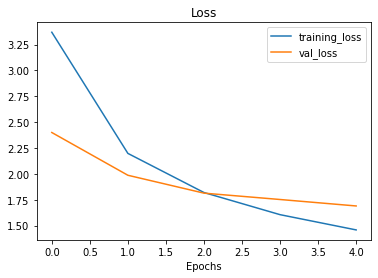

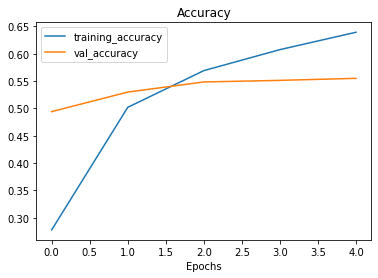

In [13]:
plot_loss_curves(history_all_classes_10_percent)

In [14]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [15]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [16]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [17]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # start from previous last epoch

Epoch 5/10
237/237 [==============================] - 59s 222ms/step - loss: 1.2080 - accuracy: 0.6850 - val_loss: 1.7040 - val_accuracy: 0.5593
Epoch 6/10
237/237 [==============================] - 47s 198ms/step - loss: 1.1025 - accuracy: 0.7047 - val_loss: 1.6490 - val_accuracy: 0.5657
Epoch 7/10
237/237 [==============================] - 45s 190ms/step - loss: 1.0085 - accuracy: 0.7306 - val_loss: 1.7078 - val_accuracy: 0.5556
Epoch 8/10
237/237 [==============================] - 44s 183ms/step - loss: 0.9553 - accuracy: 0.7403 - val_loss: 1.6550 - val_accuracy: 0.5686
Epoch 9/10
237/237 [==============================] - 43s 181ms/step - loss: 0.8955 - accuracy: 0.7613 - val_loss: 1.6431 - val_accuracy: 0.5707
Epoch 10/10
237/237 [==============================] - 43s 180ms/step - loss: 0.8249 - accuracy: 0.7848 - val_loss: 1.6724 - val_accuracy: 0.5704


In [18]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 55s 70ms/step - loss: 1.5063 - accuracy: 0.6047


[1.5063227415084839, 0.6046732664108276]

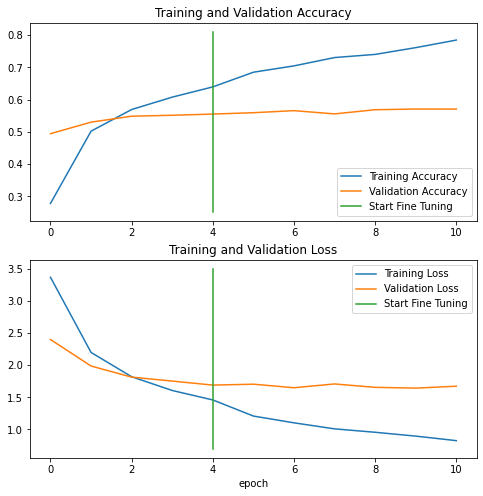

In [19]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [20]:

# Save model to drive so it can be used later 
model.save("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model")